In [145]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lenstronomy.LensModel.Profiles.gauss_decomposition import SersicEllipseGaussDec
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
import scipy.optimize as opt
from astropy.io import fits

In [146]:
def theta_E_S(c, m=1e13, z_lens=0.2, z_source=6.0, k=.1):
    factor=1.5*m/1e13
    lens_model = LensModel(['NFW', 'SERSIC_ELLIPSE_GAUSS_DEC'], z_lens=z_lens, z_source=z_source)
    lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=m, c=c)
#     print(Rs_angle, alpha_Rs)
    return opt.root(lambda x: lens_model.alpha(x,0, [{'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': 0., 'center_y': 0.}, 
                {'R_sersic': factor*np.sqrt(Rs_angle/10), 'n_sersic': 4, 'k_eff':k, 'center_x': 0., 'center_y': 0.}])[0]-x, 1).x[0]


In [147]:
masses1 = np.load("data/halo_masses.npy")
params1 = np.load("data/halo_params.npy", allow_pickle=True)
zs1 = np.load("data/halo_zs.npy")
Rs1 = np.array([d['Rs'] for d in params1])
alpha_Rs1 = np.array([d['alpha_Rs'] for d in params1])
concs1 = np.load("data/c.npy")

masses2 = np.load("data/halo_masses2.npy")
params2 = np.load("data/halo_params2.npy", allow_pickle=True)
zs2 = np.load("data/halo_zs2.npy")
Rs2 = np.array([d['Rs'] for d in params2])
alpha_Rs2 = np.array([d['alpha_Rs'] for d in params2])
concs2 = np.load("data/c2.npy")

masses = np.concatenate([masses1, masses2])
params = np.concatenate([params1, params2])
zs = np.concatenate([zs1, zs2])
Rs = np.concatenate([Rs1, Rs2])
alpha_Rs = np.concatenate([alpha_Rs1, alpha_Rs2])
concs = np.concatenate([concs1, concs2])

# masses = masses1
# params = params1
# zs = zs1
# Rs = Rs1
# alpha_Rs = alpha_Rs1

# masses2, zs2, Rs2, alpha_Rs2

In [148]:
with fits.open('/Users/ethansilver/Downloads/JADES_SF_mock_r1_v1.1.fits') as hdul:
#     print(hdul.info())
    data = hdul[1].data
    header = hdul[1].header
data = data[data['RA']>53.165]
data = data[data['RA']<53.21]
data = data[data['DEC']<-27.75]
data = data[data['DEC']>-27.835]
total_source_area = (53.21-53.165)*(-27.75+27.835)*(3600**2)/.03**2 #pixels

z_sources = np.logspace(np.log10(max(data['redshift'])), np.log10(min(data['redshift'])), 20)
z_source_means = (z_sources[1:]+z_sources[:-1])/2

In [149]:
with fits.open('/Users/ethansilver/Downloads/goods_s_F115W_2018_08_29.fits') as hdul:
    data3 = hdul[0].data
    header3 = hdul[0].header
from astropy.wcs import WCS
w = WCS(header3)
from astropy.coordinates import SkyCoord
bkg = data3[5000:5050,8000:8050]
bkg = np.std(bkg)
bkg

0.0020595375

In [202]:
TES=[]
lens_areas = np.ones(len(z_source_means))
source_areas = np.zeros(len(z_source_means))
net = np.ones(len(z_source_means))
counts = np.ones(len(z_source_means))
NORM = 10

# z_source_means = [6.0]
for zi in range(len(z_source_means)):
    print(zi, end=" ")
    sources = data[data['redshift']<z_sources[zi]]
    sources = sources[sources['redshift']>z_sources[zi+1]]
    print(len(sources))
    for source in range(len(sources)):
        R = int(sources[source]['Re_circ']/.03)
        ra, dec = sources[source]['RA'], sources[source]['DEC']
        sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
        x, y = w.world_to_pixel(sky)
        x, y = int(x), int(y)
        gal = data3[y-R:y+R,x-R:x+R]
        
        source_areas[zi] += np.count_nonzero([gal>5*bkg])/total_source_area
        

    TESz = []
    for lens in range(len(masses)):
        if zs[lens] < z_source_means[zi]:
            lens_cosmo = LensCosmo(z_lens=zs[lens], z_source=6.0)
            _, _, c, _, _ = lens_cosmo.nfw_angle2physical(Rs[lens], alpha_Rs[lens])
            c = concs[lens]
            k = c*.01*(masses[lens]/1e13)**(1/3)*(np.log10(masses[lens])-9)/(13-9)
            theta_E = theta_E_S(c, m=masses[lens], z_lens=zs[lens], z_source=z_source_means[zi], k=k)
            TESz.append(theta_E)
    TESz = np.array(TESz)
#     TESz = TESz[TESz>.03]
    lens_areas[zi] = np.sum(np.pi * TESz**2)*NORM/(11*60)**2
    TES.append(TESz)
    net[zi] = lens_areas[zi] * source_areas[zi]
    counts[zi] = len(TESz[TESz>.03])*NORM/(11*60)**2 * source_areas[zi] #per square arcsecond


0 44


KeyboardInterrupt: 

Text(0.5, 1.0, 'All Theta_Es')

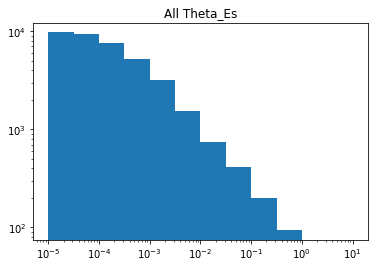

In [194]:
all_TES = []
for i in range(len(TES)):
    for j in range(len(TES[i])):
        all_TES.append(TES[i][j])
plt.hist(all_TES, bins=np.logspace(-5,1,13), log=True)
plt.xscale('log')
plt.title("All Theta_Es")

In [197]:
sum(np.array(all_TES)>.03)

737

In [177]:
for i in range(len(TES)):
    print(len(TES[i]))
len(masses)

86727
86727
86727
86727
86727
86727
86727
86727
65739
46270
32466
22408
15226
10423
6886
4433
2628
1372
517


86727

0.0009621463433751313

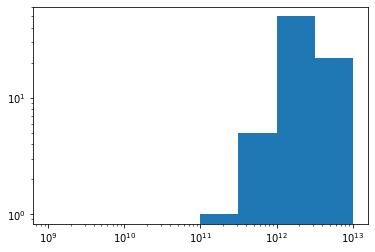

In [200]:
plt.hist(masses[TES[2]>.03], bins=np.logspace(9,13,9), log=True)
plt.xscale('log')
ind = np.argmax(TES[4]*(masses<1e10))
TES[4][ind]

(array([3.6069e+04, 3.2615e+04, 6.4750e+03, 1.2030e+03, 2.7900e+02,
        5.6000e+01, 1.8000e+01, 7.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([0.06033292, 0.26157458, 0.46281624, 0.6640579 , 0.86529956,
        1.06654122, 1.26778288, 1.46902454, 1.6702662 , 1.87150786,
        2.07274952]),
 <BarContainer object of 10 artists>)

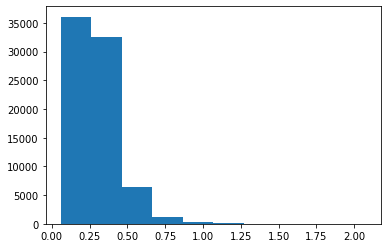

In [179]:
plt.hist(Rs[masses<1e10])

In [180]:
masses[ind]/1e9, params[ind], zs[ind], Rs[ind], alpha_Rs[ind]

(3.3686128333136374,
 {'alpha_Rs': 0.013565844228759718,
  'Rs': 0.10550266655257486,
  'center_x': 0.34577577148188854,
  'center_y': 0.32721595357495015},
 0.8150000000000001,
 0.10550266655257486,
 0.013565844228759718)

In [181]:
lens_cosmo = LensCosmo(z_lens=zs[ind], z_source=6.0)
_, _, c, _, m200 = lens_cosmo.nfw_angle2physical(Rs[ind], alpha_Rs[ind])
c, m200

(array(1477.27754682), 482378128224055.1)

In [182]:
lens_cosmo.nfw_physical2angle(M=27310498511202.54, c=334.89)

(0.1787052702290056, 32.36547022731351)

In [183]:
params[0]

{'alpha_Rs': 0.0053596300216563674,
 'Rs': 0.3984422306872419,
 'center_x': -0.36247789001284986,
 'center_y': 0.7834730976641469}

In [204]:
for i in range(len(TES)):
    print(z_source_means[i], len(TES[i][TES[i]>.03])*10)

In [162]:
all_TES = np.array(TES[10])
len(all_TES[all_TES>.03])*100

2700

In [185]:
areas = np.ones(len(z_source_means))
total = 0
for i in range(len(TES)):
    print(max(TES[i]))
    total += len(TES[i][TES[i]>.03])*10/(11*60)**2 * source_areas[i]
    TES[i] = TES[i][TES[i]<1]
    areas[i] = np.sum(np.pi * TES[i]**2)*10/(11*60)**2
total

0.9686218879086097
0.93942159169111
0.9051877005406366
0.8650182076372099
0.8179275706552607
0.7629325929170528
0.6992373555914989
0.6265706061889909
0.5456913032631138
0.49814687522333323
0.47451109612219566
0.4465231808617243
0.4139163203311823
0.37671656652611374
0.3535058718699105
0.3321389308073502
0.3074505581127473
0.01561633902367377
0.013669821697885045


1.2669290865343968e-05

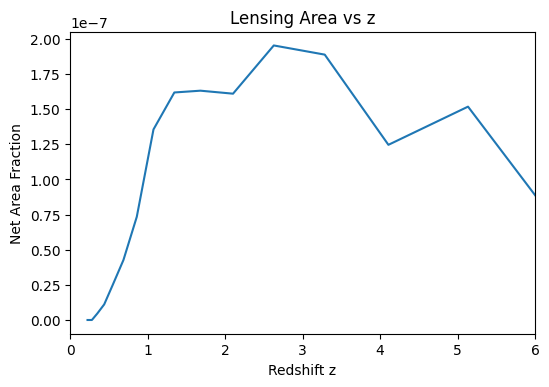

In [186]:
plt.figure(dpi=100)
plt.plot(z_source_means, source_areas*areas)
plt.xlabel('Redshift z')
plt.ylabel("Net Area Fraction")
plt.xlim(0,6)
plt.title('Lensing Area vs z');

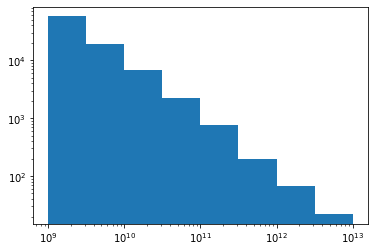

In [187]:
plt.hist(masses, log=True, bins=np.logspace(9,13,9))
plt.xscale('log')

In [188]:
source_areas

array([1.81554103e-08, 4.82933914e-06, 1.05355846e-04, 2.34531590e-04,
       6.87164125e-04, 6.45424837e-04, 1.13660131e-03, 1.38919753e-03,
       1.39744009e-03, 1.74386347e-03, 2.16368918e-03, 2.24184822e-03,
       1.83119099e-03, 1.28215323e-03, 1.39328250e-03, 7.57425563e-04,
       5.47240378e-04, 2.51724764e-04, 4.09259259e-04])

In [189]:
np.sum(source_areas)*100, np.mean(areas)*100, np.sum(source_areas)*np.mean(areas)*100

(1.8222240377631709, 0.012271690357621727, 0.00022361769153644834)

In [190]:
np.sum(counts)

1.266929086534397e-05

In [201]:
np.sum(source_areas*areas)*100, np.sum(counts)*(3600**2)*41253/1e6

(0.00015275124931836656, 6.773495478641732)

Text(0.5, 1.0, "Theta_E's at ")

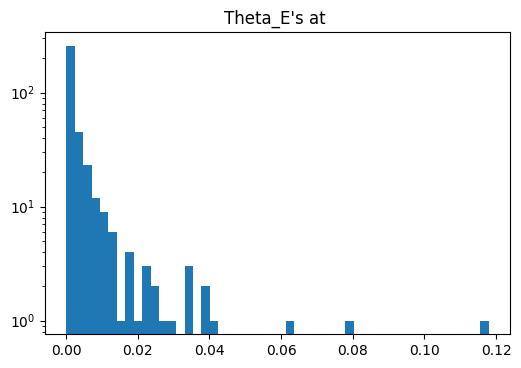

In [151]:
plt.figure(dpi=100)
TESz = np.array(TESz)
plt.hist(TESz[TESz<1], bins = 50, log=True)
plt.title("Theta_E's at ")

In [33]:
lens_cosmo = LensCosmo(0.205,6.0)
_, _, c, _, _ = lens_cosmo.nfw_angle2physical(Rs2[0], alpha_Rs2[0])
lens_cosmo.nfw_physical2angle(masses2[0], c)

(5.090871210797983, 0.10853154014701338)

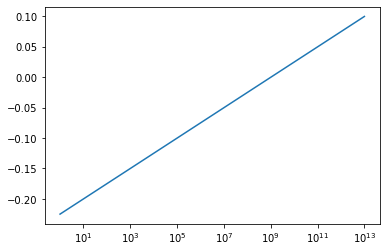

In [50]:
m = np.logspace(0,13, 100)
k = 4 * .025 * (np.log10(m)-9)/(13-9)
plt.plot(m,k)
plt.xscale('log')